<a href="https://colab.research.google.com/github/RumanaCU/Sleep-Staging/blob/main/SleepAnalysis04.26.2021.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import tensorflow as tf

In [ ]:
x = tf.constant([2, 4])

In [ ]:
y = tf.constant([2, 4])

In [ ]:
tf.math.equal(x, y)

<tf.Tensor: shape=(2,), dtype=bool, numpy=array([ True,  True])>

In [ ]:
x = tf.constant([1,4,3])

In [ ]:
y = tf.constant(2)

In [ ]:
tf.math.equal(x, y)

<tf.Tensor: shape=(3,), dtype=bool, numpy=array([False, False, False])>

In [ ]:
t = tf.constant([])

In [ ]:
t.get_shape

<bound method _EagerTensorBase.get_shape of <tf.Tensor: shape=(0,), dtype=float32, numpy=array([], dtype=float32)>>

In [ ]:
t.shape

TensorShape([0])

In [ ]:
 

is_empty = tf.equal(t.shape, 0)

print(is_empty.ndim)


1


In [ ]:
t.ndim

1

In [ ]:
a=tf.zeros

In [ ]:
print(a)

<function zeros at 0x7f2b98014050>


In [ ]:
is_zero=tf.math.count_nonzero(t)

In [ ]:
is_zero.numpy=0

In [ ]:
is_zero

<tf.Tensor: shape=(), dtype=int64, numpy=0>

In [ ]:
!pip install torch  # should already be installed on colab

In [ ]:
# Identify whether a CUDA-enabled GPU is available
import torch

if torch.cuda.is_available():
    print('CUDA-enabled GPU found. Training should be faster.')
else:
    print('No GPU found. Training will be carried out on CPU, which might be '
          'slower.\n\nIf running on Google Colab, you can request a GPU runtime by'
          ' clicking\n`Runtime/Change runtime type` in the top bar menu, then '
          'selecting \'GPU\'\nunder \'Hardware accelerator\'.')

CUDA-enabled GPU found. Training should be faster.


In [ ]:
# Install required packages for colab
!pip install mne
!pip install torch
!pip install matplotlib
!pip install scikit-learn
!pip install pandas

     |████████████████████████████████| 6.9MB 7.2MB/s 


In [ ]:
# import general modules
import os
import copy

import torch
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

%matplotlib inline

In [ ]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'

In [ ]:
device

'cuda'

In [ ]:
import mne
from mne.datasets.sleep_physionet.age import fetch_data

mne.set_log_level('ERROR')  # To avoid flooding the cell outputs with messages

In [ ]:
subjects = range(30)
recordings = [1]

# To load all subjects and recordings, uncomment the next line
# subjects, recordings = range(83), [1, 2]

In [ ]:
fnames = fetch_data(subjects=subjects, recording=recordings, on_missing='warn')

In [ ]:
fnames

[['/root/mne_data/physionet-sleep-data/SC4001E0-PSG.edf',
  '/root/mne_data/physionet-sleep-data/SC4001EC-Hypnogram.edf'],
 ['/root/mne_data/physionet-sleep-data/SC4011E0-PSG.edf',
  '/root/mne_data/physionet-sleep-data/SC4011EH-Hypnogram.edf'],
 ['/root/mne_data/physionet-sleep-data/SC4021E0-PSG.edf',
  '/root/mne_data/physionet-sleep-data/SC4021EH-Hypnogram.edf'],
 ['/root/mne_data/physionet-sleep-data/SC4031E0-PSG.edf',
  '/root/mne_data/physionet-sleep-data/SC4031EC-Hypnogram.edf'],
 ['/root/mne_data/physionet-sleep-data/SC4041E0-PSG.edf',
  '/root/mne_data/physionet-sleep-data/SC4041EC-Hypnogram.edf'],
 ['/root/mne_data/physionet-sleep-data/SC4051E0-PSG.edf',
  '/root/mne_data/physionet-sleep-data/SC4051EC-Hypnogram.edf'],
 ['/root/mne_data/physionet-sleep-data/SC4061E0-PSG.edf',
  '/root/mne_data/physionet-sleep-data/SC4061EC-Hypnogram.edf'],
 ['/root/mne_data/physionet-sleep-data/SC4071E0-PSG.edf',
  '/root/mne_data/physionet-sleep-data/SC4071EC-Hypnogram.edf'],
 ['/root/mne_dat

In [ ]:
def load_sleep_physionet_raw(raw_fname, annot_fname, load_eeg_only=True, 
                             crop_wake_mins=30):
    """Load a recording from the Sleep Physionet dataset.
    
    Parameters
    ----------
    raw_fname : str
        Path to the .edf file containing the raw data.
    annot_fname : str
        Path to the annotation file.
    load_eeg_only : bool
        If True, only keep EEG channels and discard other modalities 
        (speeds up loading).
    crop_wake_mins : float
        Number of minutes of wake events before and after sleep events.
    
    Returns
    -------
    mne.io.Raw :
        Raw object containing the EEG and annotations.        
    """
    mapping = {'EOG horizontal': 'eog',
               'Resp oro-nasal': 'misc',
               'EMG submental': 'misc',
               'Temp rectal': 'misc',
               'Event marker': 'misc'}
    exclude = mapping.keys() if load_eeg_only else ()
    
    raw = mne.io.read_raw_edf(raw_fname, exclude=exclude)
    annots = mne.read_annotations(annot_fname)
    raw.set_annotations(annots, emit_warning=False)
    if not load_eeg_only:
        raw.set_channel_types(mapping)
    
    if crop_wake_mins > 0:  # Cut start and end Wake periods
        # Find first and last sleep stages
        mask = [x[-1] in ['1', '2', '3', '4', 'R'] 
                for x in annots.description]
        sleep_event_inds = np.where(mask)[0]

        # Crop raw
        tmin = annots[int(sleep_event_inds[0])]['onset'] - \
               crop_wake_mins * 60
        tmax = annots[int(sleep_event_inds[-1])]['onset'] + \
               crop_wake_mins * 60
        raw.crop(tmin=tmin, tmax=tmax)
    
    # Rename EEG channels
    ch_names = {i: i.replace('EEG ', '') 
                for i in raw.ch_names if 'EEG' in i}
    mne.rename_channels(raw.info, ch_names)
    
    # Save subject and recording information in raw.info
    basename = os.path.basename(raw_fname)
    subj_nb, rec_nb = int(basename[3:5]), int(basename[5])
    raw.info['subject_info'] = {'id': subj_nb, 'rec_id': rec_nb}
   
    return raw

In [ ]:
# Load recordings
raws = [load_sleep_physionet_raw(f[0], f[1]) for f in fnames]

/usr/local/lib/python3.7/dist-packages/matplotlib/colors.py:263: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  c = np.array(c)


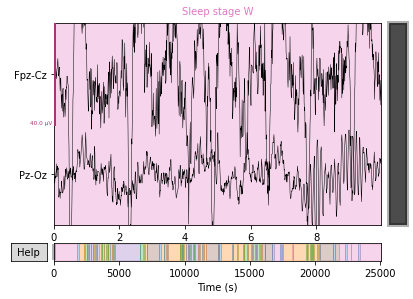

In [ ]:
# Plot a recording as a sanity check
raws[0].plot();

In [ ]:
l_freq, h_freq = None, 30

for raw in raws:
    raw.load_data().filter(l_freq, h_freq)  # filtering happens in-place

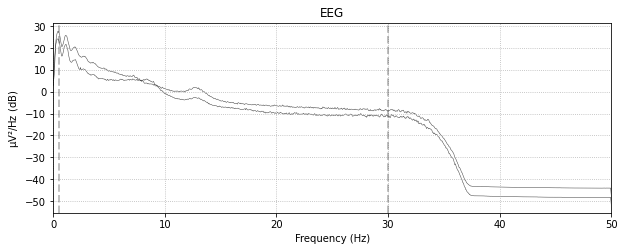

In [ ]:
# Plot the power spectrum of a recording as sanity check
raws[0].plot_psd();

In [ ]:
def extract_epochs(raw, chunk_duration=30.):
    """Extract non-overlapping epochs from raw data.
    
    Parameters
    ----------
    raw : mne.io.Raw
        Raw data object to be windowed.
    chunk_duration : float
        Length of a window.
    
    Returns
    -------
    np.ndarray
        Epoched data, of shape (n_epochs, n_channels, n_times).
    np.ndarray
        Event identifiers for each epoch, shape (n_epochs,).
    """
    annotation_desc_2_event_id = {
        'Sleep stage W': 1,
        'Sleep stage 1': 2,
        'Sleep stage 2': 3,
        'Sleep stage 3': 4,
        'Sleep stage 4': 4,
        'Sleep stage R': 5}

    events, _ = mne.events_from_annotations(
        raw, event_id=annotation_desc_2_event_id, 
        chunk_duration=chunk_duration)

    # create a new event_id that unifies stages 3 and 4
    event_id = {
        'Sleep stage W': 1,
        'Sleep stage 1': 2,
        'Sleep stage 2': 3,
        'Sleep stage 3/4': 4,
        'Sleep stage R': 5}

    tmax = 30. - 1. / raw.info['sfreq']  # tmax in included
    picks = mne.pick_types(raw.info, eeg=True, eog=True)
    epochs = mne.Epochs(raw=raw, events=events, picks=picks, preload=True,
                        event_id=event_id, tmin=0., tmax=tmax, baseline=None)
    
    return epochs.get_data(), epochs.events[:, 2] - 1

In [ ]:
from torch.utils.data import Dataset, ConcatDataset


class EpochsDataset(Dataset):
    """Class to expose an MNE Epochs object as PyTorch dataset.
    
    Parameters
    ----------
    epochs_data : np.ndarray
        The epochs data, shape (n_epochs, n_channels, n_times).
    epochs_labels : np.ndarray
        The epochs labels, shape (n_epochs,)
    subj_nb: None | int
        Subject number.
    rec_nb: None | int
        Recording number.
    transform : callable | None
        The function to eventually apply to each epoch
        for preprocessing (e.g. scaling). Defaults to None.
    """
    def __init__(self, epochs_data, epochs_labels, subj_nb=None, 
                 rec_nb=None, transform=None):
        assert len(epochs_data) == len(epochs_labels)
        self.epochs_data = epochs_data
        self.epochs_labels = epochs_labels
        self.subj_nb = subj_nb
        self.rec_nb = rec_nb
        self.transform = transform

    def __len__(self):
        return len(self.epochs_labels)

    def __getitem__(self, idx):
        X, y = self.epochs_data[idx], self.epochs_labels[idx]
        if self.transform is not None:
            X = self.transform(X)
        X = torch.as_tensor(X[None, ...])
        return X, y
    

def scale(X):
    """Standard scaling of data along the last dimention.
    
    Parameters
    ----------
    X : array, shape (n_channels, n_times)
        The input signals.
        
    Returns
    -------
    X_t : array, shape (n_channels, n_times)
        The scaled signals.
    """
    X -= np.mean(X, axis=1, keepdims=True)
    return X / np.std(X, axis=1, keepdims=True)

In [ ]:
# Apply windowing and move to pytorch dataset
all_datasets = [EpochsDataset(*extract_epochs(raw), subj_nb=raw.info['subject_info']['id'], 
                              rec_nb=raw.info['subject_info']['rec_id'], transform=scale) 
                for raw in raws]

# Concatenate into a single dataset
dataset = ConcatDataset(all_datasets)

In [ ]:
dataset[2][0]

tensor([[[ 1.7403,  1.4080,  1.3783,  ...,  1.0748,  1.0731,  0.9778],
         [ 0.4591,  1.5401,  2.3674,  ...,  0.0124, -0.2490, -0.6441]]],
       dtype=torch.float64)

In [ ]:
from sklearn.model_selection import LeavePGroupsOut


def pick_recordings(dataset, subj_rec_nbs):
    """Pick recordings using subject and recording numbers.
    
    Parameters
    ----------
    dataset : ConcatDataset
        The dataset to pick recordings from.        
    subj_rec_nbs : list of tuples
        List of pairs (subj_nb, rec_nb) to use in split.
        
    Returns
    -------
    ConcatDataset
        The picked recordings.
    ConcatDataset | None
        The remaining recordings. None if all recordings from 
        `dataset` were picked.
    """
    pick_idx = list()
    for subj_nb, rec_nb in subj_rec_nbs:
        for i, ds in enumerate(dataset.datasets):
            if (ds.subj_nb == subj_nb) and (ds.rec_nb == rec_nb):
                pick_idx.append(i)
                
    remaining_idx = np.setdiff1d(
        range(len(dataset.datasets)), pick_idx)

    pick_ds = ConcatDataset([dataset.datasets[i] for i in pick_idx])
    if len(remaining_idx) > 0:
        remaining_ds = ConcatDataset(
            [dataset.datasets[i] for i in remaining_idx])
    else:
        remaining_ds = None
    
    return pick_ds, remaining_ds
    

def train_test_split(dataset, n_groups, split_by='subj_nb'):
    """Split dataset into train and test keeping n_groups out in test.
    
    Parameters
    ----------
    dataset : ConcatDataset
        The dataset to split.
    n_groups : int
        The number of groups to leave out.
    split_by : 'subj_nb' | 'rec_nb'
        Property to use to split dataset.
        
    Returns
    -------
    ConcatDataset
        The training data.
    ConcatDataset
        The testing data.
    """
    groups = [getattr(ds, split_by) for ds in dataset.datasets]
    train_idx, test_idx = next(
        LeavePGroupsOut(n_groups).split(X=groups, groups=groups))

    train_ds = ConcatDataset([dataset.datasets[i] for i in train_idx])
    test_ds = ConcatDataset([dataset.datasets[i] for i in test_idx])
        
    return train_ds, test_ds

In [ ]:
# We seed the random number generators to make our splits reproducible
torch.manual_seed(87)
np.random.seed(87)

In [ ]:
# Use recording 1 of subjects 0-9 as test set
test_recs = [(subj_nb, rec_nb)  # DO NOT CHANGE! This is a fixed set.
             for subj_nb, rec_nb in zip(range(10), [1] * 10)]
test_ds, train_ds = pick_recordings(dataset, test_recs)

In [ ]:
train_ds[100]

(tensor([[[ 0.3502,  0.4692,  0.1789,  ...,  0.6496,  0.3633,  0.1287],
          [-0.9838, -1.3873, -1.4725,  ..., -0.7188, -0.9115, -0.8411]]],
        dtype=torch.float64), 2)

In [ ]:
# Split remaining recordings into training and validation sets
n_subjects_valid = max(1, int(len(train_ds.datasets) * 0.2))
train_ds, valid_ds = train_test_split(train_ds, n_subjects_valid, split_by='subj_nb')

print('Number of examples in each set:')
print(f'Training: {len(train_ds)}')
print(f'Validation: {len(valid_ds)}')
print(f'Test: {len(test_ds)}')

Number of examples in each set:
Training: 15463
Validation: 3082
Test: 9850


In [ ]:
import pandas as pd
train_ds1 = pd.DataFrame(train_ds)
test_ds1 = pd.DataFrame(test_ds)
valid_ds1 = pd.DataFrame(valid_ds)

NameError: ignored

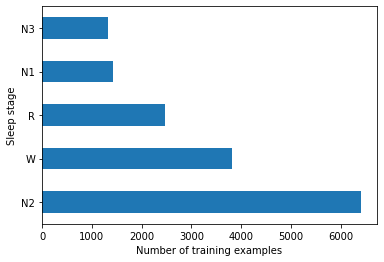

In [ ]:
classes_mapping = {0: 'W', 1: 'N1', 2: 'N2', 3: 'N3', 4: 'R'}
y_train = pd.Series([y for _, y in train_ds]).map(classes_mapping)
ax = y_train.value_counts().plot(kind='barh')
ax.set_xlabel('Number of training examples');
ax.set_ylabel('Sleep stage');

In [ ]:
y_train

0        W
1        W
2        W
3        W
4        W
        ..
15458    W
15459    W
15460    W
15461    W
15462    W
Length: 15463, dtype: object

In [ ]:
# Computing class weight
from sklearn.utils.class_weight import compute_class_weight

train_y = np.concatenate([ds.epochs_labels for ds in train_ds.datasets])
class_weights = compute_class_weight('balanced', classes=np.unique(train_y), y=train_y)
print(class_weights)

[0.80788924 2.15662483 0.4824649  2.32701279 1.25613323]


In [ ]:
y_train

0        W
1        W
2        W
3        W
4        W
        ..
15458    W
15459    W
15460    W
15461    W
15462    W
Length: 15463, dtype: object

In [ ]:
from torch.utils.data import DataLoader

In [ ]:
train_ds

In [ ]:
loader = DataLoader(
    dataset,
    shuffle=False,
    num_workers=0,
    batch_size=128
)

for data in loader:
    print(data[0])

Streaming output truncated to the last 5000 lines.


        [[[-1.9296, -2.1750, -1.4496,  ...,  0.1934,  0.1187,  0.6094],
          [ 0.0490,  1.0321,  1.0321,  ...,  0.2068,  0.1219,  0.1097]]],


        [[[ 1.1262,  0.6353,  0.2947,  ...,  0.1745,  0.2246, -0.0358],
          [ 0.0504,  0.3388,  0.5485,  ..., -0.5001, -0.6574, -0.6049]]],


        ...,


        [[[-0.4488, -0.2338,  0.8171,  ...,  0.3174,  0.3689,  0.1720],
          [-1.4875, -1.6501,  1.5132,  ...,  0.0793,  1.5871, -0.3641]]],


        [[[ 0.5513,  0.4927,  0.5723,  ...,  0.5513,  0.5053,  0.5890],
          [-0.2816, -1.7608, -0.2816,  ..., -1.0339, -1.6460, -1.4675]]],


        [[[ 0.5763,  0.4955,  0.4576,  ..., -0.1027, -0.3021, -0.4350],
          [-2.4685, -1.5943, -1.0855,  ..., -0.3939, -0.0938, -0.1460]]]],
       dtype=torch.float64)
tensor([[[[-3.2120e-01, -3.4634e-01, -2.8887e-01,  ..., -2.6201e+00,
           -2.6165e+00, -2.5518e+00],
          [ 3.9623e-01, -8.8918e-02, -9.2810e-01,  ..., -1

In [ ]:
train_batch_size = 1  # Important hyperparameter
valid_batch_size = 1  # Can be made as large as what fits in memory; won't impact performance
num_workers = 0  # Number of processes to use for the data loading process; 0 is the main Python process

loader_train = DataLoader(
    train_ds, batch_size=train_batch_size, shuffle=True, num_workers=num_workers)
loader_valid = DataLoader(
    valid_ds, batch_size=valid_batch_size, shuffle=False, num_workers=num_workers)
loader_test = DataLoader(
    test_ds, batch_size=valid_batch_size, shuffle=False, num_workers=num_workers)

In [ ]:
tr=np.array(train_ds)

ValueError: ignored

In [ ]:
len(loader_test)

9850

In [ ]:
len(loader_train)

15463

In [ ]:
batch_size = 128
num_classes = 5
epochs = 100


In [ ]:
import tensorflow.keras as keras
from keras.models import Model
from keras.models import Sequential
from keras.layers import Conv1D, ZeroPadding1D, MaxPooling1D, BatchNormalization, Activation, Dropout, Flatten, Dense

In [ ]:
sfreq = raws[0].info['sfreq']  # Sampling frequency
n_channels = raws[0].info['nchan']  # Number of channels
input_size_s=30
input_size=int(input_size_s * sfreq)

In [ ]:
input_size

3000

In [ ]:
input_shape=(input_size, 1)

In [ ]:
input_shape=(3000,1)

In [ ]:
n_channels

2

In [ ]:
sfreq

100.0

In [ ]:
input_shape

(3000, 1)

In [ ]:
from keras.layers import Input
newInput = Input(batch_shape=(3000,1))

In [ ]:
newInput

<KerasTensor: shape=(3000, 1) dtype=float32 (created by layer 'input_2')>

In [ ]:
model = Sequential()
model.add(Conv1D(64, kernel_size=5,strides=3, padding = "same",activation="relu", input_shape=input_shape))
model.add(Conv1D(128, kernel_size=5,strides=1, padding = "same",activation="relu", input_shape=input_shape))
model.add(MaxPooling1D(pool_size=(2)))
model.add(Dropout(0.2))
model.add(Conv1D(128, kernel_size=13,strides=1, padding = "same",activation="relu"))
model.add(Conv1D(256, kernel_size=7,strides=1, padding = "same",activation="relu"))
model.add(MaxPooling1D(pool_size=(2)))
model.add(Conv1D(256,kernel_size=7,strides=1, padding = "same", activation="relu"))
model.add(Conv1D(64,kernel_size=4,strides=1, padding = "same", activation="relu"))
model.add(MaxPooling1D(pool_size=(2)))
model.add(Conv1D(32,kernel_size=3,strides=1, padding = "same", activation="relu"))
model.add(Conv1D(64,kernel_size=6,strides=1, padding = "same", activation="relu"))
model.add(MaxPooling1D(pool_size=(2)))
model.add(Conv1D(8,kernel_size=5,strides=1, padding = "same", activation="relu"))
model.add(Conv1D(8,kernel_size=2,strides=1, padding = "same", activation="relu"))
model.add(MaxPooling1D(pool_size=(2)))
model.add(Flatten())
model.add(Dense(64, activation="relu"))
model.add(Dropout(0.2))
model.add(Dense(num_classes, activation="softmax"))
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d (Conv1D)              (None, 1000, 64)          384       
_________________________________________________________________
conv1d_1 (Conv1D)            (None, 1000, 128)         41088     
_________________________________________________________________
max_pooling1d (MaxPooling1D) (None, 500, 128)          0         
_________________________________________________________________
dropout (Dropout)            (None, 500, 128)          0         
_________________________________________________________________
conv1d_2 (Conv1D)            (None, 500, 128)          213120    
_________________________________________________________________
conv1d_3 (Conv1D)            (None, 500, 256)          229632    
_________________________________________________________________
max_pooling1d_1 (MaxPooling1 (None, 250, 256)          0

In [ ]:
model.compile(loss=keras.losses.MeanSquaredError,
              optimizer='adam',
              metrics=['accuracy'])

In [ ]:
import pandas as pd

train_x = pd.DataFrame(loader_train)
test_x = pd.DataFrame(loader_test)
train_y=pd.DataFrame(y_train)



In [ ]:
train_y

,0
0,W
1,W
2,W
3,W
4,W
...,...
15458,W
15459,W
15460,W
15461,W


In [ ]:
train_x

,0,1
0,"[[[tensor([-1.2933, -0.9369, -1.1186, ..., -0...",[tensor(1)]
1,"[[[tensor([7.6767e-01, 1.1230e+00, 1.3045e+00,...",[tensor(0)]
2,"[[[tensor([ 0.7409, 0.7311, 0.7197, ..., -2...",[tensor(2)]
3,"[[[tensor([-0.1017, 0.5555, -0.3466, ..., 2...",[tensor(1)]
4,"[[[tensor([-0.2683, -0.7251, -0.5561, ..., -0...",[tensor(1)]
...,...,...
15458,"[[[tensor([-0.1434, -0.0687, -0.3242, ..., 0...",[tensor(1)]
15459,"[[[tensor([1.2742, 1.1967, 1.1115, ..., 0.659...",[tensor(4)]
15460,"[[[tensor([-0.1852, -0.1364, -0.0437, ..., -1...",[tensor(0)]
15461,"[[[tensor([ 1.0656, 1.3737, 1.6616, ..., 0...",[tensor(3)]


In [ ]:
len(train_y)

15463

In [ ]:
train_x=np.asarray(loader_train)

In [ ]:
train_x=np.asarray(train_x).astype(np.float32)

TypeError: ignored

In [ ]:
len(train_x)

TypeError: ignored

In [ ]:
test_x

,0,1
0,"[[[tensor([ 0.3842, 0.8294, 1.0075, ..., -0...","[tensor(0), tensor(0), tensor(0), tensor(0), t..."
1,"[[[tensor([-0.8096, -0.5088, -0.0043, ..., 0...","[tensor(4), tensor(4), tensor(4), tensor(4), t..."
2,"[[[tensor([-0.9429, -0.8522, -0.7240, ..., 0...","[tensor(3), tensor(3), tensor(3), tensor(3), t..."
3,"[[[tensor([0.6978, 1.4083, 1.7688, ..., 0.803...","[tensor(0), tensor(0), tensor(0), tensor(0), t..."
4,"[[[tensor([ 0.5288, 0.5753, 0.6863, ..., -1...","[tensor(3), tensor(3), tensor(3), tensor(3), t..."
5,"[[[tensor([0.4944, 0.6718, 0.5796, ..., 0.437...","[tensor(2), tensor(2), tensor(2), tensor(1), t..."
6,"[[[tensor([-0.8107, -1.0677, -1.1036, ..., -0...","[tensor(2), tensor(2), tensor(2), tensor(2), t..."
7,"[[[tensor([0.6215, 1.1584, 1.5782, ..., 1.915...","[tensor(2), tensor(2), tensor(2), tensor(2), t..."
8,"[[[tensor([ 0.6945, 0.2766, -0.0764, ..., 0...","[tensor(2), tensor(2), tensor(2), tensor(2), t..."
9,"[[[tensor([0.4592, 0.4426, 0.4842, ..., 0.800...","[tensor(4), tensor(0), tensor(1), tensor(2), t..."


In [ ]:
x = []
for i in range(145):
    x.append([])
data = np.random.rand(2,145,3000, 1)
for data_vector in data:
    for index in range(145):
        x[index].append(data_vector[index])  
   
y = np.random.rand(2,39)
print('x',np.asarray(x).shape)
print('y',y.shape)



x (145, 2, 3000, 1)
y (2, 39)


In [ ]:
import tensorflow as tf
#Considering y variable holds numpy array
y_tensor = tf.convert_to_tensor(train_y, dtype=tf.string) 


In [ ]:
tf.dtypes.as_dtype(y_train)


tf.string

In [ ]:
tf.dtypes.as_dtype(train_x)

tf.string

In [ ]:
model.fit(train_x, y_train,
          batch_size=batch_size,
          epochs=epochs)

ValueError: ignored

In [ ]:
class SleepModel(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv1d(3, 6, 5)
        self.pool = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(6, 16, 5)
        self.fc1 = nn.Linear(16 * 5 * 5, 120)
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84, 10)

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = x.view(-1, 16 * 5 * 5)
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x


In [ ]:
from torch import nn


class SleepModelRumana(nn.Module):
    
    def __init__(self, n_channels, sfreq, n_classes=5):
        super().__init__()

        input_size = int(input_size_s * sfreq)
        
        len_last_layer = self._len_last_layer(
            n_channels, input_size, max_pool_size, n_conv_chs)

        if n_channels > 1:
            self.spatial_conv = nn.Conv2d(1, n_channels, (n_channels, 1))

        self.feature_extractor = nn.Sequential(
            nn.Conv2d(
                1, n_conv_chs, (1, time_conv_size), padding=(0, pad_size)),
            nn.ReLU(),
            nn.MaxPool2d((1, max_pool_size)),
            nn.Conv2d(
                n_conv_chs, n_conv_chs, (1, time_conv_size),
                padding=(0, pad_size)),
            nn.ReLU(),
            nn.MaxPool2d((1, max_pool_size))
        )
        self.fc = nn.Sequential(
            nn.Dropout(dropout),
            nn.Linear(len_last_layer, n_classes)
        )

    @staticmethod
    def _len_last_layer(n_channels, input_size, max_pool_size, n_conv_chs):
        return n_channels * (input_size // (max_pool_size ** 2)) * n_conv_chs

    def forward(self, x):
        """Forward pass.
        
        Parameters
        ---------
        x: torch.Tensor
            Batch of EEG windows of shape (batch_size, n_channels, n_times).
        """
        if self.n_channels > 1:
            x = self.spatial_conv(x)
            x = x.transpose(1, 2)

        x = self.feature_extractor(x)
        return self.fc(x.flatten(start_dim=1))

In [ ]:
model = Sequential()
input_shape=(input_size, 1)
model.add(Conv1D(128, kernel_size=3,padding = "same",activation="relu", input_shape=input_shape))
model.add(BatchNormalization())
model.add(MaxPooling1D(pool_size=(2)))
model.add(Conv1D(128,kernel_size=3,padding = "same", activation="relu"))
model.add(BatchNormalization())
model.add(MaxPooling1D(pool_size=(2)))
model.add(Flatten())
model.add(Dense(64, activation="tanh"))
model.add(Dropout(0.2))
model.add(Dense(32, activation="tanh"))
model.add(Dropout(0.2))
model.add(Dense(16, activation="relu"))
model.add(Dropout(0.2))
model.add(Dense(num_classes, activation="softmax"))
model.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d (Conv1D)              (None, 3000, 128)         512       
_________________________________________________________________
batch_normalization (BatchNo (None, 3000, 128)         512       
_________________________________________________________________
max_pooling1d (MaxPooling1D) (None, 1500, 128)         0         
_________________________________________________________________
conv1d_1 (Conv1D)            (None, 1500, 128)         49280     
_________________________________________________________________
batch_normalization_1 (Batch (None, 1500, 128)         512       
_________________________________________________________________
max_pooling1d_1 (MaxPooling1 (None, 750, 128)          0         
_________________________________________________________________
flatten (Flatten)            (None, 96000)            

In [ ]:
model = "sequential_3"

Using device 'cuda'.


NameError: ignored

In [ ]:
from torch import nn
x = torch.ones((239, 49, 5))
x = x.permute((0, 2, 1))  # permuate feature and temporal channels
print(x.shape)
model = nn.Conv1d(5, 5, 49, groups=5, bias=False)  # remove bias and set window same as whole sequence of temporal data
nn.init.constant_(model.weight, 2.)  # set kernel to one (instead of random)
output = model(x)
print(output.shape)

torch.Size([239, 5, 49])
torch.Size([239, 5, 1])


In [ ]:
sfreq = raws[0].info['sfreq']  # Sampling frequency
n_channels = raws[0].info['nchan']  # Number of channels
input_size_s=30
input_size=int(input_size_s * sfreq)
n_conv_chs=64
time_conv_size_s=0.05
max_pool_size_s=0.125
n_classes=5
dropout=0.25

In [ ]:
n_channels

2

In [ ]:
sfreq

100.0

In [ ]:
time_conv_size = int(time_conv_size_s * sfreq)
max_pool_size = int(max_pool_size_s * sfreq)
input_size = int(input_size_s * sfreq)
pad_size = time_conv_size // 2

In [ ]:
pad_size

2

In [ ]:
input_size

3000

In [ ]:
time_conv_size

5

In [ ]:
max_pool_size

12

In [ ]:
nn.Conv2d(1, n_conv_chs, (1, time_conv_size), padding=(0, pad_size))

Conv2d(1, 8, kernel_size=(1, 50), stride=(1, 1), padding=(0, 25))

In [ ]:
x=torch.ones(3000,1,1,1)


In [ ]:
model=nn.Conv1d(1, n_conv_chs, (1, time_conv_size), padding=(0, pad_size))

In [ ]:
output = model(x)

In [ ]:
print(output.shape)

torch.Size([3000, 64, 1, 1])


In [ ]:
from torch import nn


class SleepStageRumana(nn.Module):
    """Sleep staging architecture from [1]_.
    
    Convolutional neural network for sleep staging described in [1]_.
    
    Parameters
    ----------
    n_channels : int
        Number of EEG channels.
    sfreq : float
        EEG sampling frequency.
    n_conv_chs : int
        Number of convolutional channels. Set to 8 in [1]_.
    time_conv_size_s : float
        Size of filters in temporal convolution layers, in seconds. Set to 0.5
        in [1]_ (64 samples at sfreq=128).
    max_pool_size_s : float
        Max pooling size, in seconds. Set to 0.125 in [1]_ (16 samples at
        sfreq=128).
    n_classes : int
        Number of classes.
    input_size_s : float
        Size of the input, in seconds.
    dropout : float
        Dropout rate before the output dense layer.
        
    References
    ----------
    .. [1] Chambon, S., Galtier, M. N., Arnal, P. J., Wainrib, G., &
           Gramfort, A. (2018). A deep learning architecture for temporal sleep
           stage classification using multivariate and multimodal time series.
           IEEE Transactions on Neural Systems and Rehabilitation Engineering,
           26(4), 758-769.
    """
    def __init__(self, n_channels, sfreq, n_conv_chs=64, time_conv_size_s=0.5,
                 max_pool_size_s=0.125, n_classes=5, input_size_s=30,
                 dropout=0.2):
        super().__init__()

        time_conv_size = int(time_conv_size_s * sfreq)
        max_pool_size = 2
        input_size = int(input_size_s * sfreq)
        pad_size = time_conv_size // 2
        self.n_channels = n_channels
        len_last_layer = self._len_last_layer(
            n_channels, input_size, max_pool_size, n_conv_chs)

        if n_channels > 1:
            self.spatial_conv = nn.Conv2d(1, n_channels, (n_channels, 1))

        self.feature_extractor = nn.Sequential(
            nn.Conv2d(
                1, 64, (1, 5),stride=3,  padding=(0, pad_size)),
            nn.ReLU(),
            nn.Conv2d(
                64, 128, (1, 5), padding=(0, pad_size)),
            nn.ReLU(),
            nn.MaxPool2d((1,2), stride=2),
            nn.Dropout(0.2),
            nn.Conv2d(
                128, 256, (1, 13),
                padding=(0, pad_size)),
            nn.ReLU(),
            nn.Conv2d(
                256, 256, (1, 7),
                padding=(0, pad_size)),
            nn.ReLU(),
            nn.MaxPool2d((1,2), stride=2),
            nn.Conv2d(
                256, 128, (1, 7),
                padding=(0, pad_size)),
            nn.ReLU(),
            nn.Conv2d(
                128, 64, (1, 4),
                padding=(0, pad_size)),
            nn.ReLU(),
            nn.MaxPool2d((1,2), stride=2),
            nn.Conv2d(
                64, 32, (1, 3),
                padding=(0, pad_size)),
            nn.ReLU(),
            nn.Conv2d(
                32, 64, (1, 6),
                padding=(0, pad_size)),
            nn.ReLU(),
            nn.MaxPool2d((1,2), stride=2),
            nn.Conv2d(
                64, 8, (1, 5),
                padding=(0, pad_size)),
            nn.ReLU(),
            nn.Conv2d(
                8, 8, (1, 2),
                padding=(0, pad_size)),
            nn.ReLU(),
            nn.MaxPool2d((1,2), stride=2),
           
        )
        self.fc = nn.Sequential(
            nn.Linear(1,64),
            nn.ReLU(),
            nn.Dropout(0.2),
            nn.Linear(1, n_classes)
        )

    @staticmethod
    def _len_last_layer(n_channels, input_size, max_pool_size, n_conv_chs):
        return n_channels * (input_size // (max_pool_size ** 2)) * n_conv_chs

    def forward(self, x):
        """Forward pass.
        
        Parameters
        ---------
        x: torch.Tensor
            Batch of EEG windows of shape (batch_size, n_channels, n_times).
        """
        if self.n_channels > 1:
            x = self.spatial_conv(x)
            x = x.transpose(1, 2)

        x = self.feature_extractor(x)
        return self.fc(x.flatten(start_dim=1))

In [ ]:
sfreq = raws[0].info['sfreq']  # Sampling frequency
n_channels = raws[0].info['nchan']  # Number of channels

model = SleepStageRumana(n_channels, sfreq, n_classes=5)

NameError: ignored

In [ ]:
print(f'Using device \'{device}\'.')
model = model.to(device)

Using device 'cpu'.


In [ ]:
from torch.utils.data import DataLoader

# Create dataloaders
train_batch_size = 128  # Important hyperparameter
valid_batch_size = 256  # Can be made as large as what fits in memory; won't impact performance
num_workers = 0  # Number of processes to use for the data loading process; 0 is the main Python process

loader_train = DataLoader(
    train_ds, batch_size=train_batch_size, shuffle=True, num_workers=num_workers)
loader_valid = DataLoader(
    valid_ds, batch_size=valid_batch_size, shuffle=False, num_workers=num_workers)
loader_test = DataLoader(
    test_ds, batch_size=valid_batch_size, shuffle=False, num_workers=num_workers)

In [ ]:
from sklearn.metrics import balanced_accuracy_score, cohen_kappa_score

def _do_train(model, loader, optimizer, criterion, device, metric):
    # training loop
    model.train()
    
    train_loss = np.zeros(len(loader))
    y_pred_all, y_true_all = list(), list()
    for idx_batch, (batch_x, batch_y) in enumerate(loader):
        optimizer.zero_grad()
        batch_x = batch_x.to(device=device, dtype=torch.float32)
        batch_y = batch_y.to(device=device, dtype=torch.int64)

        output = model(batch_x)
        loss = criterion(output, batch_y)

        loss.backward()
        optimizer.step()
        
        y_pred_all.append(torch.argmax(output, axis=1).cpu().numpy())
        y_true_all.append(batch_y.cpu().numpy())

        train_loss[idx_batch] = loss.item()
        
    y_pred = np.concatenate(y_pred_all)
    y_true = np.concatenate(y_true_all)
    perf = metric(y_true, y_pred)
    
    return np.mean(train_loss), perf
        

def _validate(model, loader, criterion, device, metric):
    # validation loop
    model.eval()
    
    val_loss = np.zeros(len(loader))
    y_pred_all, y_true_all = list(), list()
    with torch.no_grad():
        for idx_batch, (batch_x, batch_y) in enumerate(loader):
            batch_x = batch_x.to(device=device, dtype=torch.float32)
            batch_y = batch_y.to(device=device, dtype=torch.int64)
            output = model.forward(batch_x)

            loss = criterion(output, batch_y)
            val_loss[idx_batch] = loss.item()
            
            y_pred_all.append(torch.argmax(output, axis=1).cpu().numpy())
            y_true_all.append(batch_y.cpu().numpy())
            
    y_pred = np.concatenate(y_pred_all)
    y_true = np.concatenate(y_true_all)
    perf = metric(y_true, y_pred)

    return np.mean(val_loss), perf


def train(model, loader_train, loader_valid, optimizer, criterion, n_epochs, 
          patience, device, metric=None):
    """Training function.
    
    Parameters
    ----------
    model : instance of nn.Module
        The model.
    loader_train : instance of Sampler
        The generator of EEG samples the model has to train on.
        It contains n_train samples
    loader_valid : instance of Sampler
        The generator of EEG samples the model has to validate on.
        It contains n_val samples. The validation samples are used to
        monitor the training process and to perform early stopping
    optimizer : instance of optimizer
        The optimizer to use for training.
    n_epochs : int
        The maximum of epochs to run.
    patience : int
        The patience parameter, i.e. how long to wait for the
        validation error to go down.
    metric : None | callable
        Metric to use to evaluate performance on the training and
        validation sets. Defaults to balanced accuracy.
        
    Returns
    -------
    best_model : instance of nn.Module
        The model that led to the best prediction on the validation
        dataset.
    history : list of dicts
        Training history (loss, accuracy, etc.)
    """
    best_valid_loss = np.inf
    best_model = copy.deepcopy(model)
    waiting = 0
    history = list()
    
    if metric is None:
        metric = balanced_accuracy_score
        
    print('epoch \t train_loss \t valid_loss \t train_perf \t valid_perf')
    print('-------------------------------------------------------------------')

    for epoch in range(1, n_epochs + 1):
        train_loss, train_perf = _do_train(
            model, loader_train, optimizer, criterion, device, metric=metric)
        valid_loss, valid_perf = _validate(
            model, loader_valid, criterion, device, metric=metric)
        history.append(
            {'epoch': epoch, 
             'train_loss': train_loss, 'valid_loss': valid_loss,
             'train_perf': train_perf, 'valid_perf': valid_perf})
        
        print(f'{epoch} \t {train_loss:0.4f} \t {valid_loss:0.4f} '
              f'\t {train_perf:0.4f} \t {valid_perf:0.4f}')

        # model saving
        if valid_loss < best_valid_loss:
            print(f'best val loss {best_valid_loss:.4f} -> {valid_loss:.4f}')
            best_valid_loss = valid_loss
            best_model = copy.deepcopy(model)
            waiting = 0
        else:
            waiting += 1

        # model early stopping
        if waiting >= patience:
            print(f'Stop training at epoch {epoch}')
            print(f'Best val loss : {best_valid_loss:.4f}')
            break

    return best_model, history

In [ ]:
from torch.nn import CrossEntropyLoss
from torch.optim import Adam

optimizer = Adam(model.parameters(), lr=1e-3, weight_decay=0)
criterion = CrossEntropyLoss(weight=torch.Tensor(class_weights).to(device))

In [ ]:
n_epochs = 10
patience = 5

best_model, history = train(
    model, loader_train, loader_valid, optimizer, criterion, n_epochs, patience, 
    device, metric=cohen_kappa_score)

epoch 	 train_loss 	 valid_loss 	 train_perf 	 valid_perf
-------------------------------------------------------------------


RuntimeError: ignored